In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


def preprocess_data(data, seq_length, pred_length):
    X, y = [], []
    for i in range(seq_length, len(data) - pred_length):
        X.append(data[i - seq_length:i, 0])
        y.append(data[i: i + pred_length, 0])
    return np.array(X), np.array(y)


df = pd.read_csv('egauge_data.csv')

# Convert the 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y %H:%M')

# Sort the DataFrame by date
df.sort_values(by='Date', inplace=True)

# Set 'Date' as the index
df.set_index('Date', inplace=True)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Usage_kW'].values.reshape(-1, 1))

# Sequence lengths to experiment with
sequence_lengths = [60, 90, 120] 
best_mse = float('inf')
best_length = 0

for seq_length in sequence_lengths:
    # Preprocess data for each sequence length
    X, y = preprocess_data(scaled_data, seq_length, 60)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    # Split data into train and test
    train_size = int(0.67 * len(X))
    X_train, y_train = X[:train_size], y[:train_size]
    X_test, y_test = X[train_size:], y[train_size:]

    # Build LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(60))
    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

    # Train model
    history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stop, model_checkpoint])

    # Validate model
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    y_test_original = scaler.inverse_transform(y_test)

    mse = mean_squared_error(y_test_original, predictions)
    print(f"Sequence Length: {seq_length}, Mean Squared Error: {mse}")

    if mse < best_mse:
        best_mse = mse
        best_length = seq_length

print(f"Best Sequence Length: {best_length} with MSE: {best_mse}")

# Load the best model
best_model = tf.keras.models.load_model('best_model.h5')

# Forecast next 60 values
last_seq_vals = scaled_data[-best_length:]
last_seq_vals = last_seq_vals.reshape(1, best_length, 1)
forecast = best_model.predict(last_seq_vals)
forecast = scaler.inverse_transform(forecast)

print(f"Forecasted values for next hour: {forecast}")

Epoch 1/100
467/467 [==============================] - 42s 80ms/step - loss: 0.0100 - val_loss: 0.0070
Epoch 2/100
467/467 [==============================] - 39s 84ms/step - loss: 0.0076 - val_loss: 0.0067
Epoch 3/100
467/467 [==============================] - 34s 72ms/step - loss: 0.0072 - val_loss: 0.0066
Epoch 4/100
467/467 [==============================] - 34s 73ms/step - loss: 0.0069 - val_loss: 0.0061
Epoch 5/100
467/467 [==============================] - 34s 74ms/step - loss: 0.0067 - val_loss: 0.0061
Epoch 6/100
467/467 [==============================] - 34s 72ms/step - loss: 0.0066 - val_loss: 0.0062
Epoch 7/100
467/467 [==============================] - 37s 78ms/step - loss: 0.0065 - val_loss: 0.0061
Epoch 8/100
467/467 [==============================] - 37s 79ms/step - loss: 0.0064 - val_loss: 0.0062
Epoch 9/100
467/467 [==============================] - 39s 84ms/step - loss: 0.0063 - val_loss: 0.0065
Epoch 9: early stopping
460/460 [==============================] - 10s 19

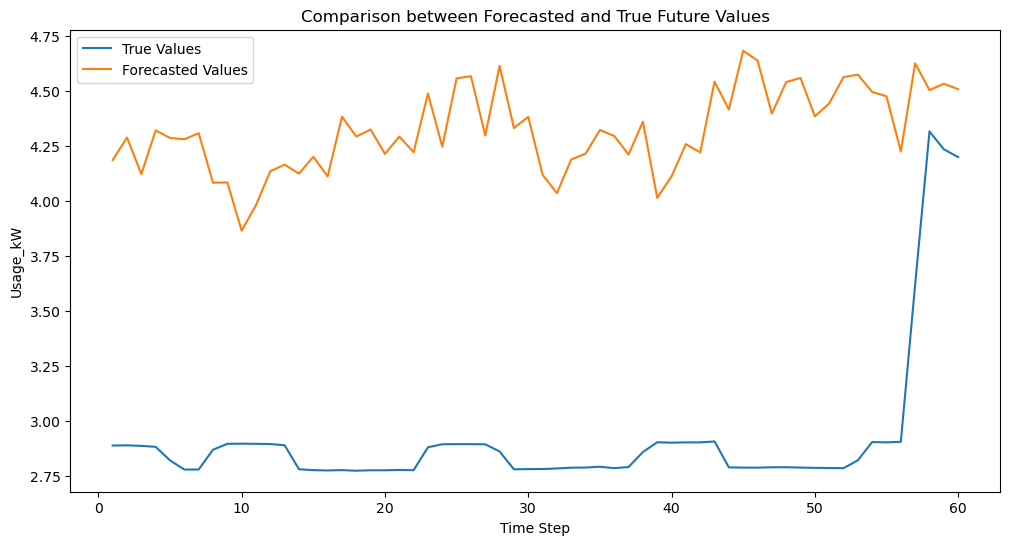

In [2]:
import matplotlib.pyplot as plt

# Retrieve the last sequence of the test data for comparison
last_sequence_true = y_test_original[-1]

# Plot comparison
plt.figure(figsize=(12, 6))
plt.plot(range(1, 61), last_sequence_true, label='True Values')
plt.plot(range(1, 61), forecast[0], label='Forecasted Values')
plt.title('Comparison between Forecasted and True Future Values')
plt.xlabel('Time Step')
plt.ylabel('Usage_kW')
plt.legend()
plt.show()